[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/azadlab/FExGAN-Meta/blob/master/FExGAN-Meta_Demo.ipynb)

# Explore the Expression: Facial Expression Generation using Auxiliary Classifier Generative Adversarial Network

In [1]:
import tensorflow as tf

import os
import time
from os import path
from matplotlib import pyplot as plt

import datetime
import numpy as np
import pathlib
import random

## Loading Model

In [5]:
!pip install gdown

  Using cached gdown-4.2.0-py3-none-any.whl
  Using cached beautifulsoup4-4.10.0-py3-none-any.whl (97 kB)
  Using cached filelock-3.4.2-py3-none-any.whl (9.9 kB)
  Using cached soupsieve-2.3.1-py3-none-any.whl (37 kB)


In [21]:
import gdown
encoder_url = "https://drive.google.com/uc?id=1BvDB67KMfgyBKNOssD1ZKg436RZidbTr"
decoder_url = "https://drive.google.com/uc?id=16Tfov5uM9ynwOYmlay7xepx_psifVDw8"
!mkdir "FExGAN-Meta"
!mkdir "models"
gdown.download(encoder_url,'FExGAN-Meta/models/encoder.h5',quiet=False)
gdown.download(decoder_url,'FExGAN-Meta/models/decoder.h5',quiet=False)



Downloading...
From: https://drive.google.com/uc?id=1R79d61-1ffkAVgJ4MQUQ70ki1PVJpvkh
To: D:\projs\Research\Code\DeepCV\publications\FExGAN_Demo\decoder.h5
100%|█████████████████████████████████████████████████████████████████████████████| 77.9M/77.9M [00:06<00:00, 11.4MB/s]


'decoder.h5'

In [4]:
encoder = tf.keras.models.load_model("FExGAN-Meta/models/encoder_model.h5")
decoder = tf.keras.models.load_model("FExGAN-Meta/models/decoder_model.h5")

encoder.summary()
decoder.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
label_input (InputLayer)        [(None, 7)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16384)        131072      label_input[0][0]                
__________________________________________________________________________________________________
img_input (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 128, 128, 1)  0           dense[0][0]                      
______________________________________________________________________________________________

## Results

## Using only decoder to generate random samples

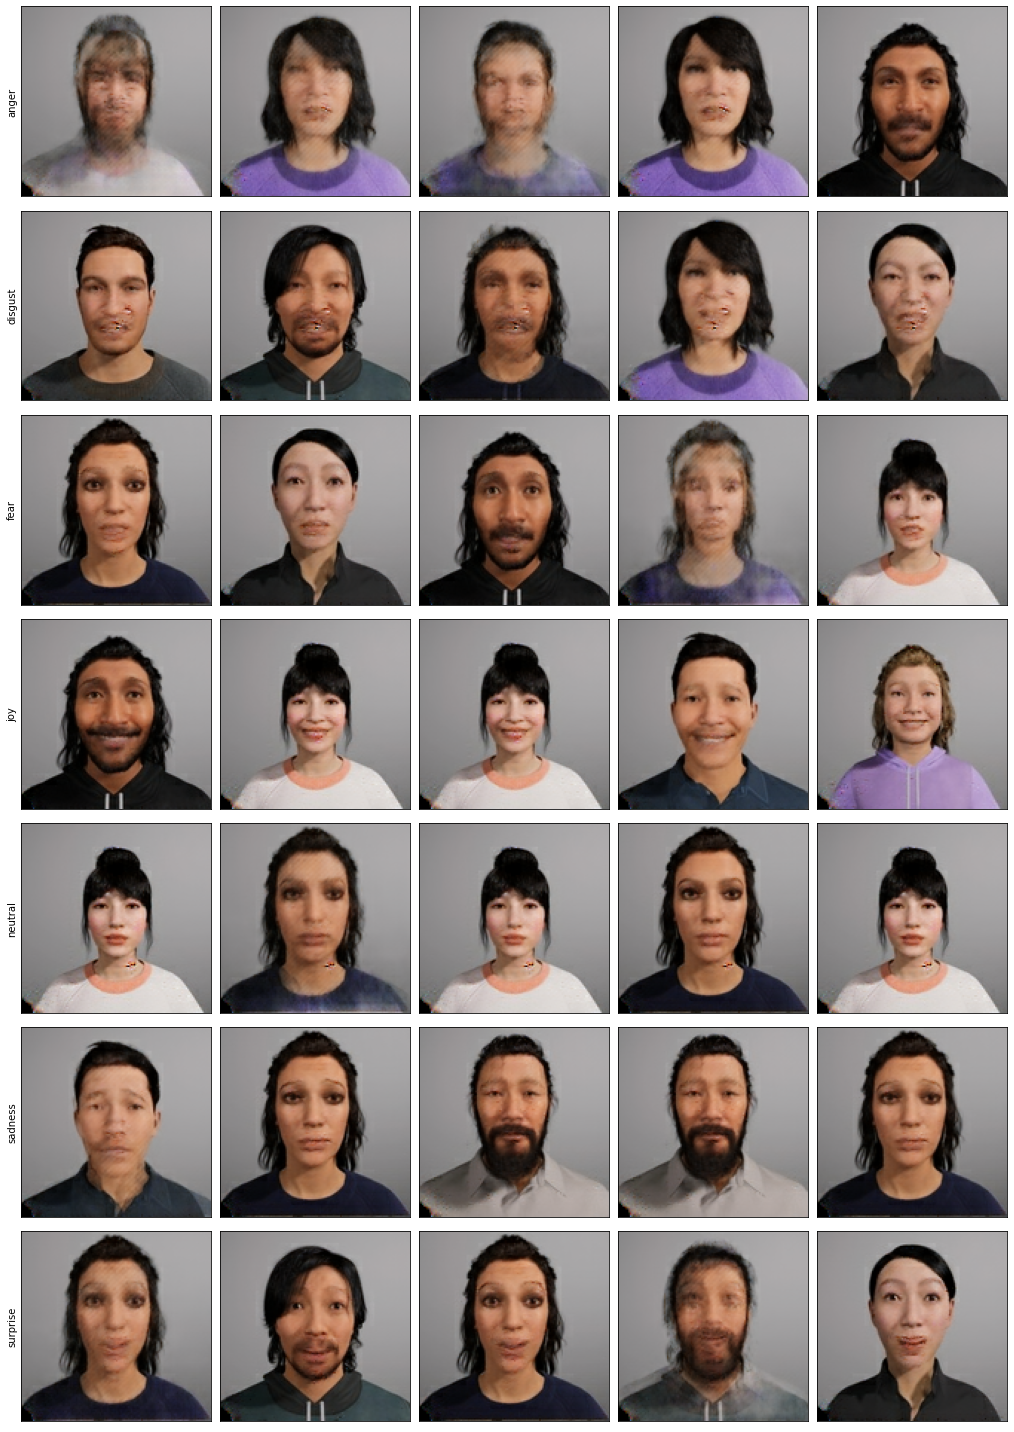

In [16]:
latent_dim = 128
num_characters = 10
num_classes = 7

affects = ["anger","disgust","fear","joy","neutral","sadness","surprise"]

fig = plt.figure(figsize=(15, 20))

fig.subplots_adjust(left=0.01, right=0.99,  wspace=0.01)

for i in range(7):
    latent_space = np.random.normal(0, 1, (5, latent_dim))
    lbl = np.zeros(shape=(5,7))
    lbl[:,i] = np.random.normal(0,1)
    fake = decoder.predict([latent_space,lbl])
    for j in range(5):
        
        ax = fig.add_subplot(7,5, 5*i+j+1)
        img = (0.5*fake[j,:,:,:]+0.5)
        img = np.array(img)  
        ax.imshow(img)
        ax.set_yticks([])
        ax.set_xticks([])
        if(j==0):
            ax.set_ylabel(affects[i])
fig.tight_layout()

In [13]:
import glob
def load_test_images(img_dir):
    img_files = glob.glob(img_dir+"/*.jpg")
    latent_vecs = []
    conditions = []
    imgs = []
    for img_file in img_files:
        
        img = tf.io.read_file(img_file)
        img =  tf.image.decode_png(img,channels=3)
        imgs.append(img)
        img = tf.cast(img, tf.float32)
        img = (img / 127.5) - 1
        img = tf.reshape(img,shape=(1,128,128,3))
        lbl  = tf.constant([0,0,0,0,1,0,0])              #Assuming that the test images are in neutral emotion (otherwise change this accordingly)
        lbl = tf.reshape(lbl,shape=(1,7))
        latent_vec,mu,sigma = encoder.predict([img,lbl])
        conditions.append(lbl)
        latent_vecs.append(mu)        
    return imgs,latent_vecs,conditions

In [6]:
import gdown
import zipfile
gdown.download('https://github.com/azadlab/FExGAN-Meta/raw/master/test.zip','FExGAN-Meta/test.zip',quiet=False)
!unzip "FExGAN-Meta/test"

Downloading...
From: https://github.com/azadlab/FExGAN/test.tar
To: D:\projs\Research\Code\DeepCV\publications\FExGAN_Demo\test.tar
 22%|███████████████████▌                                                                   | 9.00/40.0 [00:00<?, ?B/s]
'untar' is not recognized as an internal or external command,
operable program or batch file.


## Generating Affect Images from Neutral Image input and a desired Affect Condition

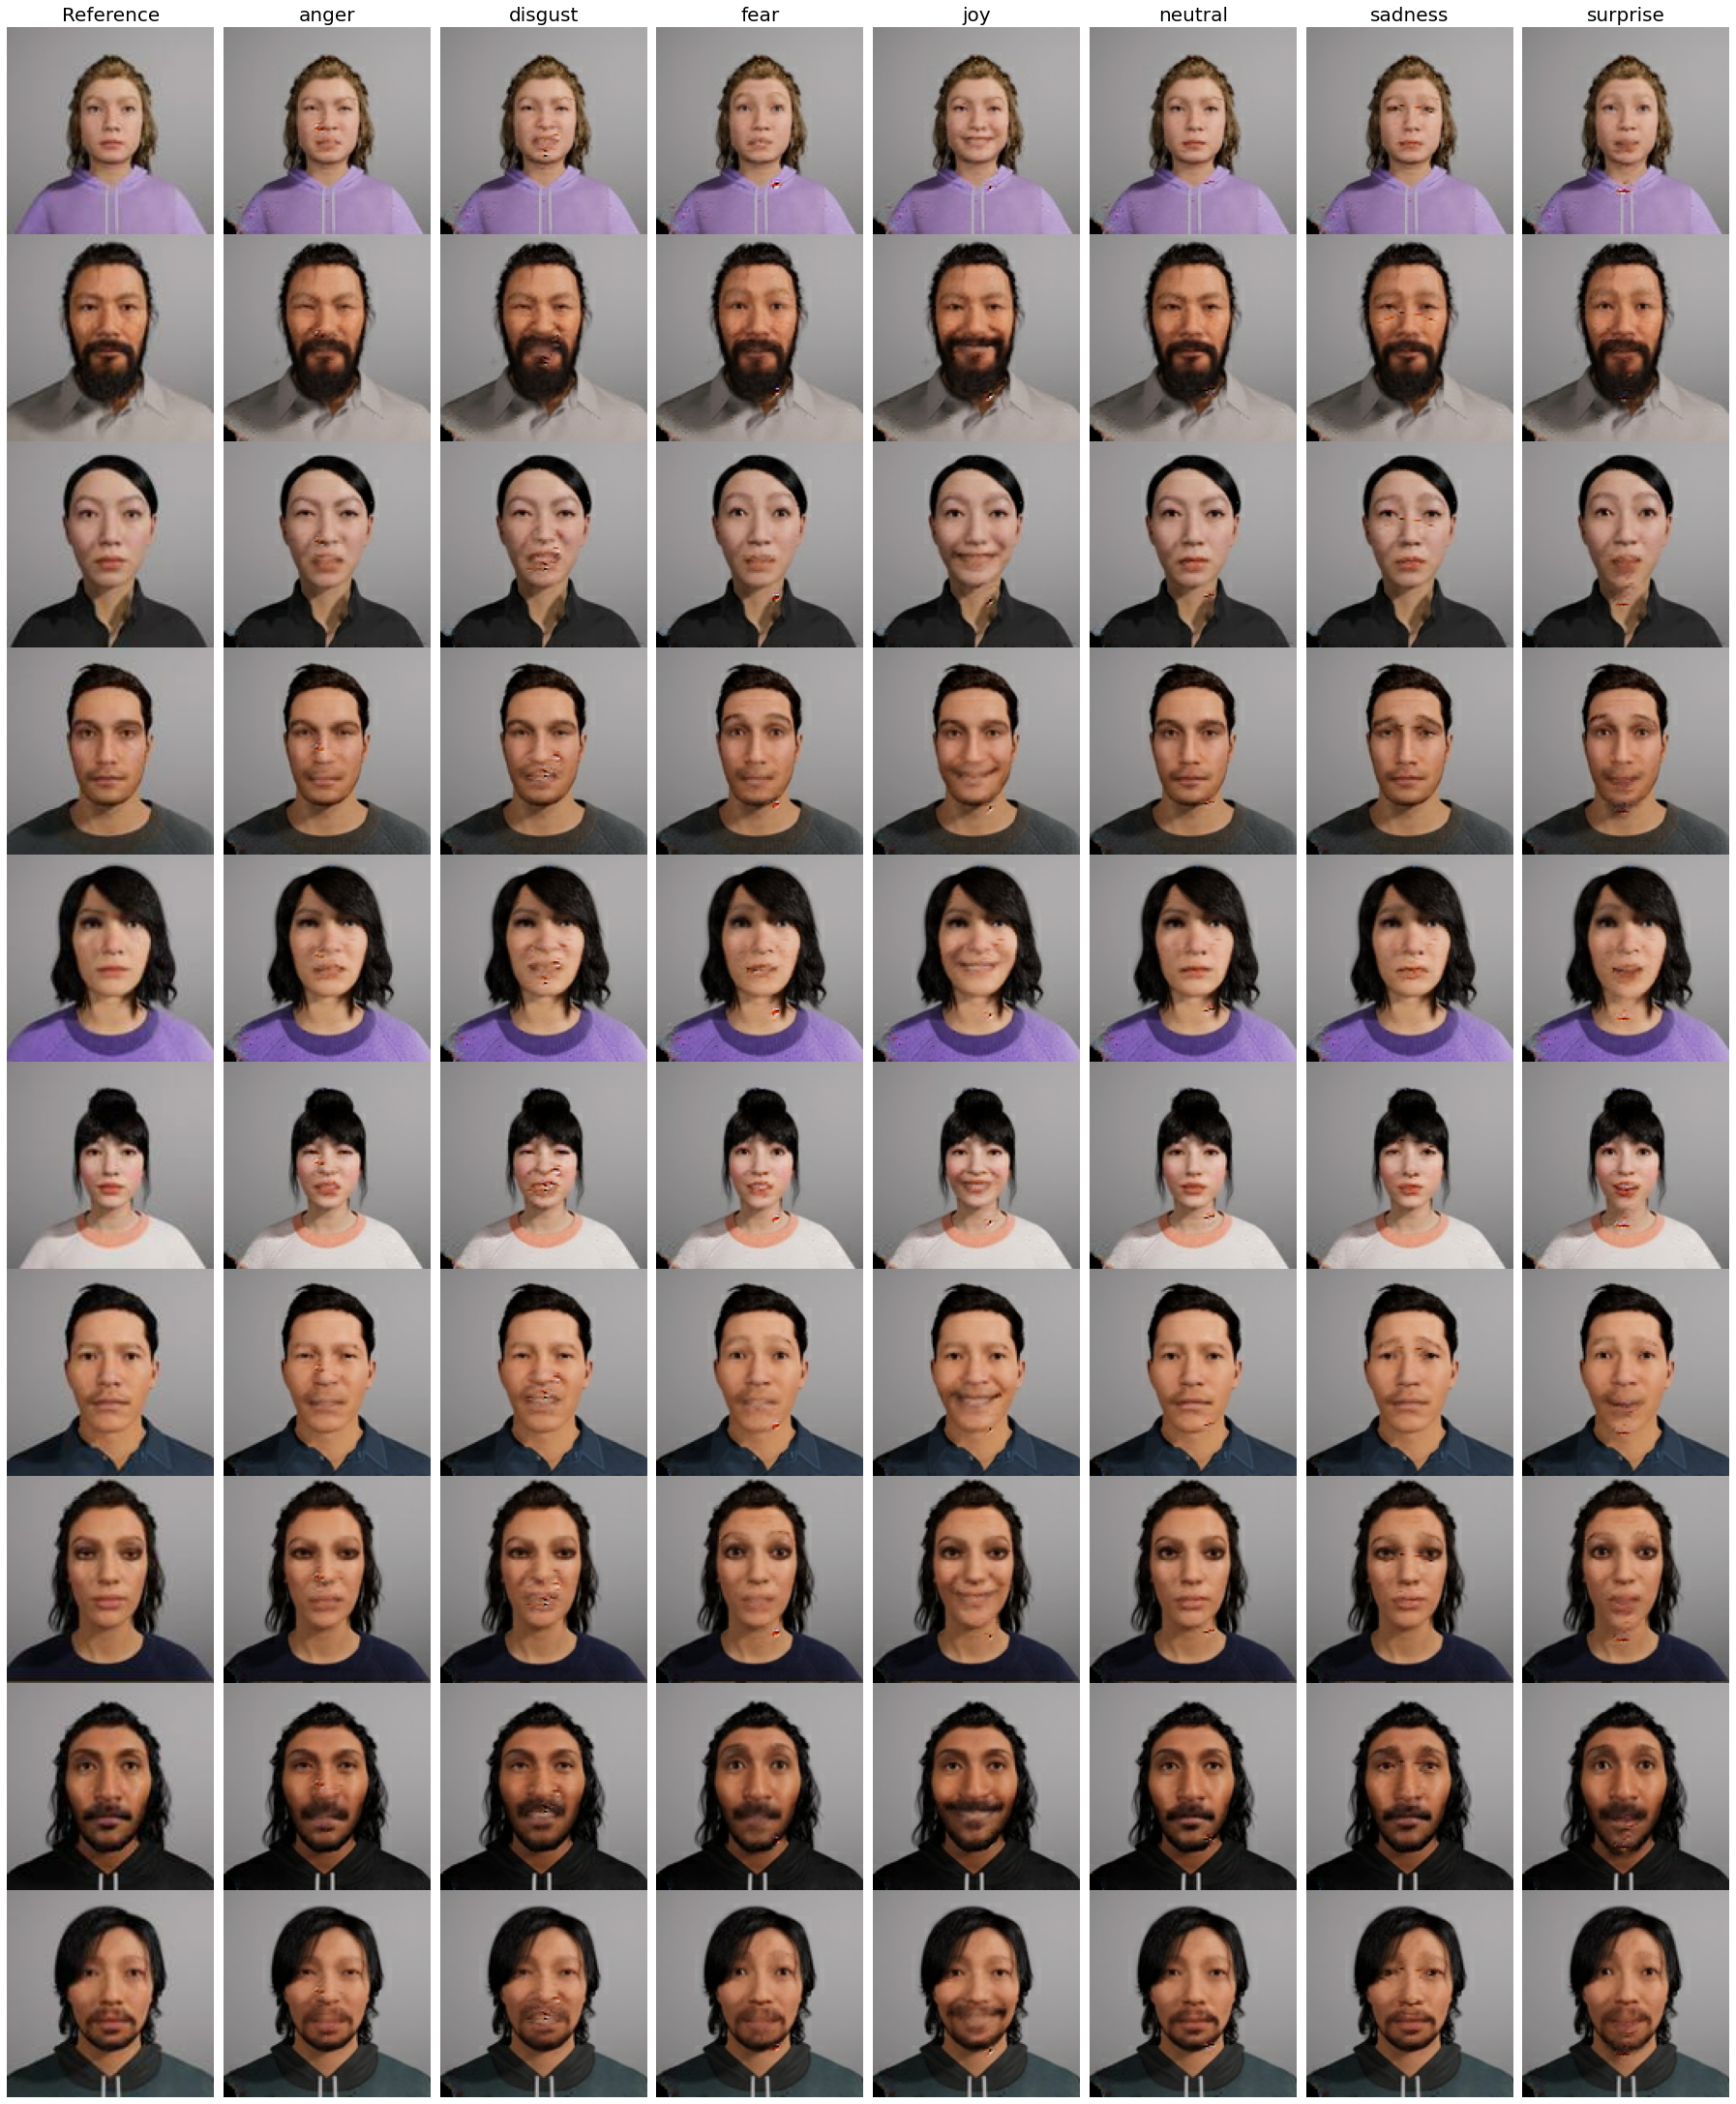

In [17]:
ref_imgs,latent_vecs,conditions = load_test_images("FExGAN-Meta/test")

fig, axes = plt.subplots(num_characters, num_classes+1,figsize=(25,30))


for k,ref_img,mu,condition in zip(range(0,num_characters),ref_imgs,latent_vecs,conditions):
    ax = axes[k][0]
    ax.imshow(ref_imgs[k])
    
    if(k==0):
        ax.set_title("Reference", fontsize=20)
    ax.axis('off')
    for i in range(1,num_classes+1):
            lbl  = np.zeros(num_classes)
            lbl[i-1] = 1
            lbl = lbl.reshape((1,num_classes))
            fake = decoder.predict([mu,lbl])
            fake = tf.reshape(fake,shape=(128,128,3))
            fake = (0.5*fake+0.5)
            ax = axes[k][i]
            ax.imshow(fake)
            ax.axis('off')
            if(k==0):
                ax.set_title(affects[i-1], fontsize=20)
line = plt.Line2D((.125,.125),(0.01,.98), color="w", linewidth=3)
fig.add_artist(line)
fig.tight_layout(pad=0, w_pad=0, h_pad=0)

## Generating Mixed Expressions

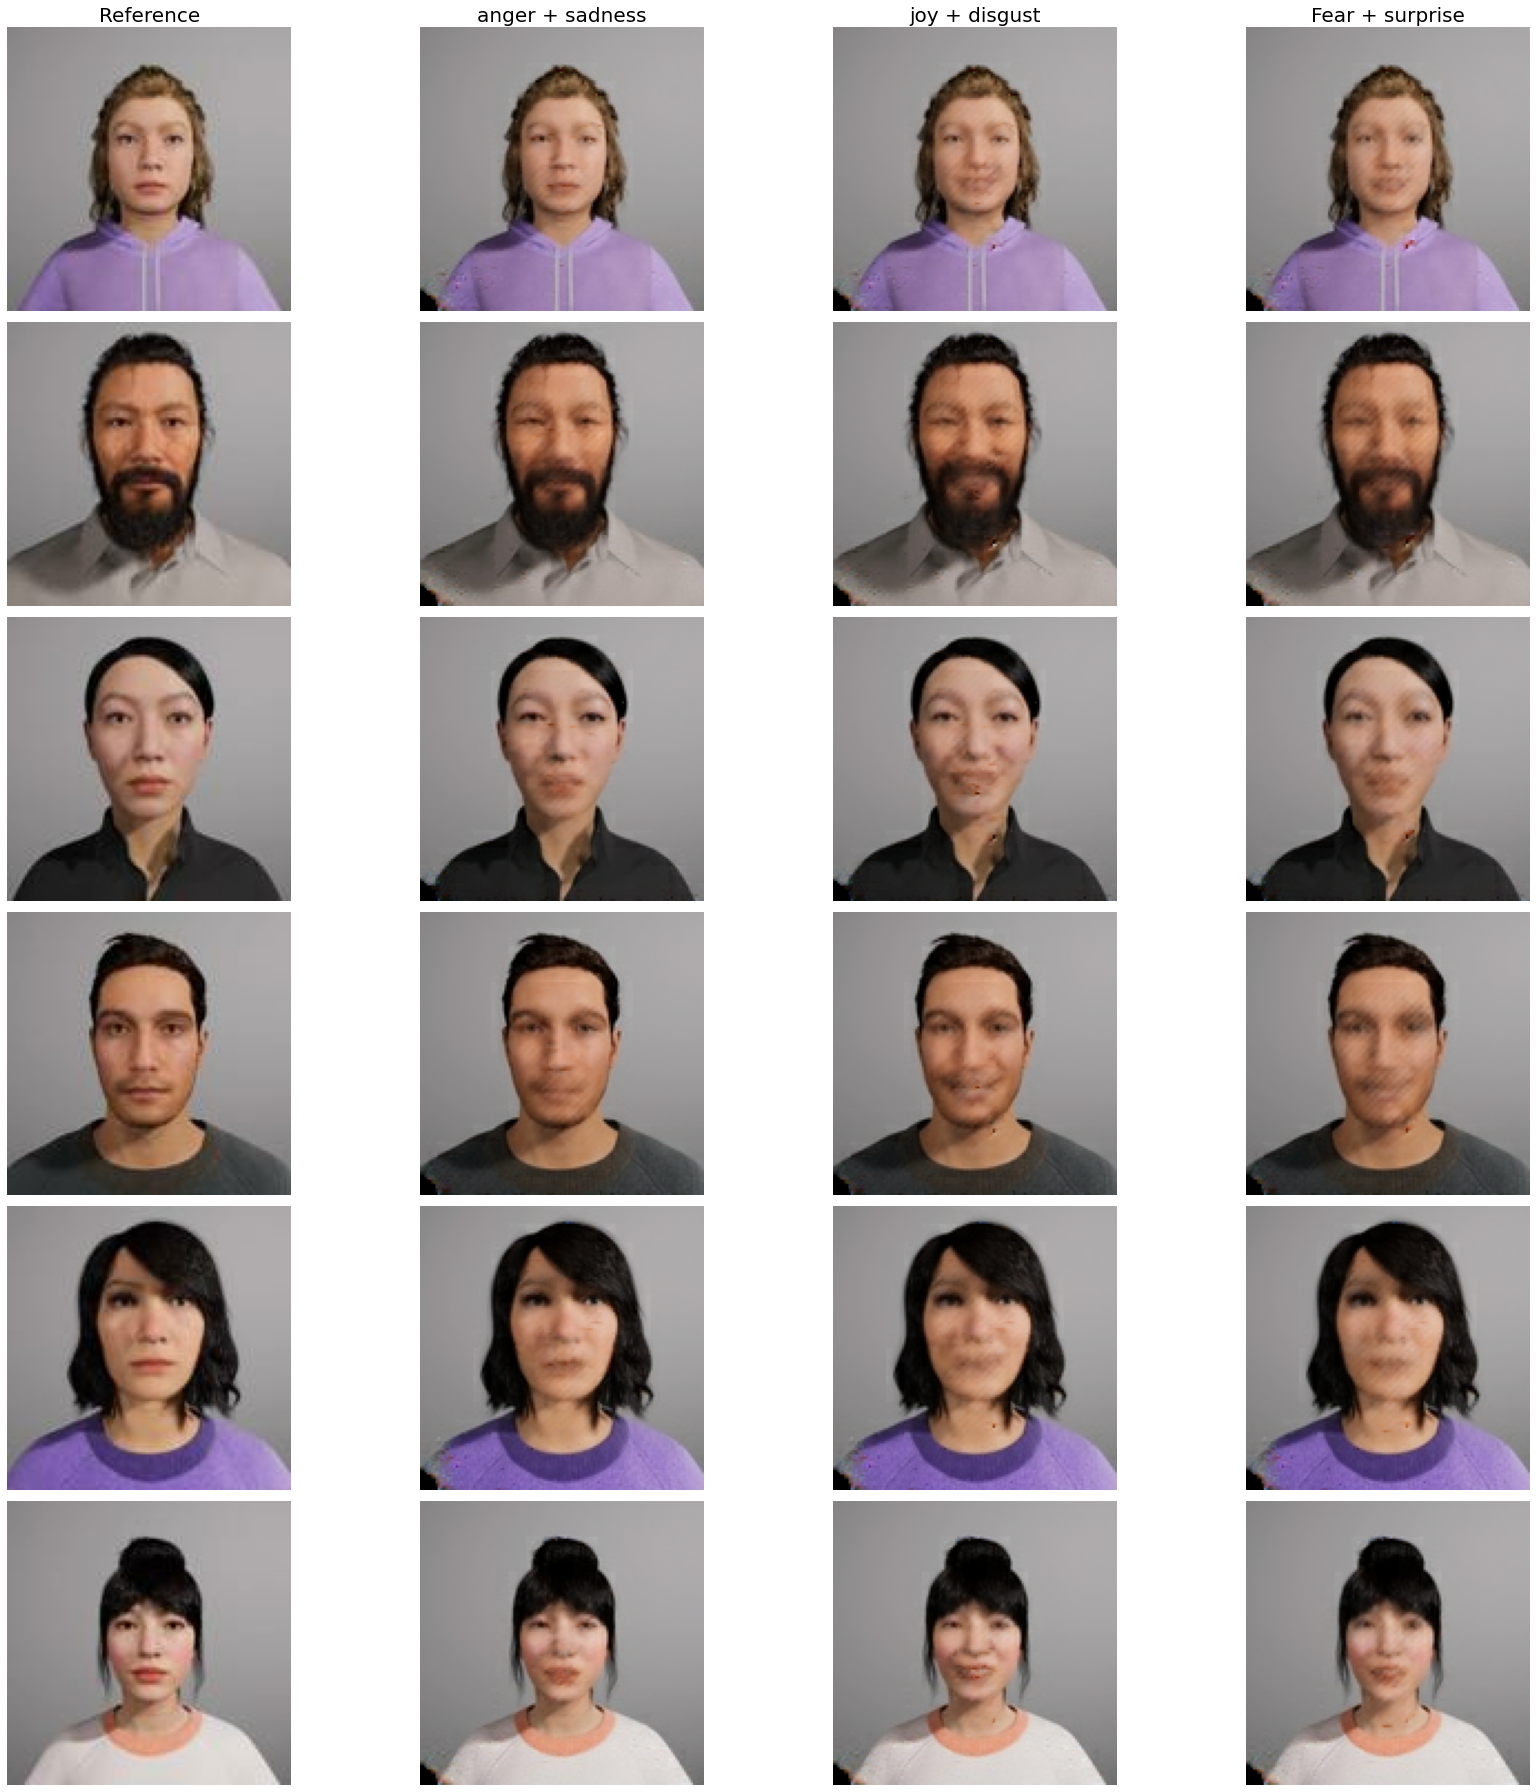

In [18]:
fig, axes = plt.subplots(6, 4,figsize=(25,25))
fig.subplots_adjust(wspace=0.01, hspace=0.1)
mixed_affects = ["anger + sadness","joy + disgust","Fear + surprise"]

lbls  = np.zeros(shape=(3,7))
lbls[0,:] = [0.6,0,0,0,0,0.7,0]   #anger + sadness
lbls[1,:] = [0,0.8,0,1,0,0,0]   #joy + disgust
lbls[2,:] = [0,0,0.8,0,0,0,0.75]   #Fear + surprise


for k,ref_img,mu,condition in zip(range(0,6),ref_imgs,latent_vecs,conditions):
    ax = axes[k][0]
    ax.imshow(ref_img)
    
    if(k==0):
        ax.set_title("Reference", fontsize=20)
    ax.axis('off')
    for i in range(1,4):
            lbl = lbls[i-1,:]
            lbl = lbl.reshape((1,7))
            
            fake = decoder.predict([mu,lbl])
            fake = tf.reshape(fake,shape=(128,128,3))
            fake = (0.5*fake+0.5)
            ax = axes[k][i]
            ax.imshow(fake)
            ax.axis('off')
            if(k==0):
                ax.set_title(mixed_affects[i-1], fontsize=20)
fig.tight_layout()


## Animation


In [20]:
from PIL import Image

affect_variation = np.linspace(-1,1,100)
imgs = []
src_idx = 4
lbl  = np.zeros(7)
    
for tar_idx in range(num_classes):
    
    for k in range(10):
        big_img = np.zeros((128*2,128*5,3))
        lbl[tar_idx] += 0.1
        affect = lbl.reshape((1,7))
        for i,mu in zip(range(len(latent_vecs)),latent_vecs):
                
                pred = decoder.predict([mu,affect])
                img = tf.reshape(pred,shape=(128,128,3))
                img = (0.5*img+0.5)
                if(i<5):
                    big_img[0:128,i*128:i*128+128,:] = img
                if(i>=5):
                    big_img[128:256,(i-5)*128:(i-5)*128+128,:] = img
        imgs.append(Image.fromarray(np.uint8(big_img*255),mode='RGB'))

    lbl[tar_idx] = 0

In [22]:
gif = []
for img in imgs:
    gif.append(img.convert("P",palette=Image.ADAPTIVE))
gif[0].save("FExGAN-Meta.gif", format='GIF', append_images=gif[1:],save_all=True, duration=150, loop=0)